In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque

%matplotlib inline

In [2]:
env = gym.make('CartPole-v0')

# Note: We can make it stable by adding a large number or subtracting a large number
def sigmoid(x):
    return x / (1.0 + np.exp(-x))

def dsigmoid(x):
    return sigmoid(x) * (1.0 - sigmoid(x))

# ToFix
class SimplePolicy:
    # input_size = state_size and output_size = action_size
    def __init__(self, lr, input_size, output_size):
        self.lr = lr
        self.w = np.random.rand(input_size, output_size).astype(np.float32)
        
    def forward(self, state):
        return sigmoid(self.w.T.dot(state))
    
    # Note: w += lr * dU
    def update(self, state, expected_reward):
        # 4x2 += 4x2
        l = self.forward(state)
        numerator = dsigmoid(l)
        numerator *= l
        self.w += self.lr * (numerator / l)
        
class Policy(nn.Module):
    def __init__(self, lr, input_size=4, output_size=2):
        super(Policy, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.LeakyReLU(),
            nn.Linear(64, output_size)
        )
    
    def forward(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        outputs = self.layers(state)
        return torch.softmax(outputs, dim=1)
    
    # Max P(episode) * R(episode)
    def update(self, optim, U):
        loss = torch.stack(U).sum()
        optim.zero_grad()
        # Note: Backprop through Pr(episode) * R(episode)
        loss.backward()
        optim.step()

Episode 1830	Average Score: 194.54
Achieved, successfully, 195.01 in 1734 episodes


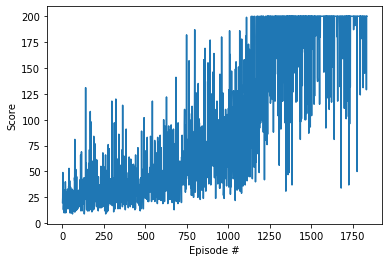

In [3]:
def run(env, optim, nepisodes):
    rewards = deque(maxlen=100)
    scores = []

    gamma = 1.0
    
    print_every = 10
    
    for episode_idx in range(1, nepisodes + 1):
        state = env.reset()
        
        # U(w) = SUM[P(trajectory;w)*R(trajectory)]
        episode_rewards = []; log_probs = []
        
        while True:
            action_probs = policy.forward(state)
            action_probs = action_probs.squeeze(0)
            
            # We need to sample from these probabilities
            action = np.random.choice(np.arange(env.action_space.n), p=action_probs.clone().detach().numpy())
            
            # grad[ log(policy_w) ]
            log_probs.append(torch.log(action_probs[action]))
    
            next_state, reward, done, _ = env.step(action)
            
            episode_rewards.append(reward)
            
            state = next_state
            
            if done:
                break
                
        # Collect stats
        rewards.append(sum(episode_rewards))
        scores.append(sum(episode_rewards))
                
        # We want to max the probability for maximizing the expected return for a trajectory (episode)
        ER =  sum([ (gamma ** idx) * R for idx, R in enumerate(episode_rewards) ])
        # Note: We need the negative sign as torch optimizes w_t+1 = w_t - lr * gradL = w_t - lr * (- gradU) = w_t + lr * gradU
        U = [ -log_probs[idx] * ER for idx in range(0, len(log_probs)) ]
        policy.update(optim, U)
            
        if episode_idx % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_idx, np.mean(rewards)), end='')
            
        if np.mean(rewards) >= 195:
            print(f'\nAchieved, successfully, {np.mean(rewards)} in {max(0, episode_idx - 100)} episodes')
            break
        
    return scores
        
lr = 1e-3
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
policy = Policy(lr, input_size, output_size).cpu()
optim = optim.Adam(policy.parameters(), lr = lr)
scores = run(env, optim, nepisodes=2000)

# Print the scores (logarithmic scale)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()